#  🚄 Data and model parallelism

In this guide, `jax` machinery for array sharding is used to achieve model and data parallelism.

Reference: [jax docs](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html)

## Imports

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet
!pip install ml_collections --quiet
!pip install tqdm --quiet

In [1]:
import os

# config XLA to show 8 devices
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import serket as sk
import jax
from jax.experimental import mesh_utils
import jax.numpy as jnp
import jax.random as jr
import jax.sharding as js
import matplotlib.pyplot as plt
import functools as ft
import optax
from ml_collections import ConfigDict
from tqdm.notebook import tqdm

## Devices and mesh setup

In [2]:
devices = mesh_utils.create_device_mesh((8))
mesh = js.Mesh(devices.reshape(4, 2), axis_names=("model", "data"))

## Data 

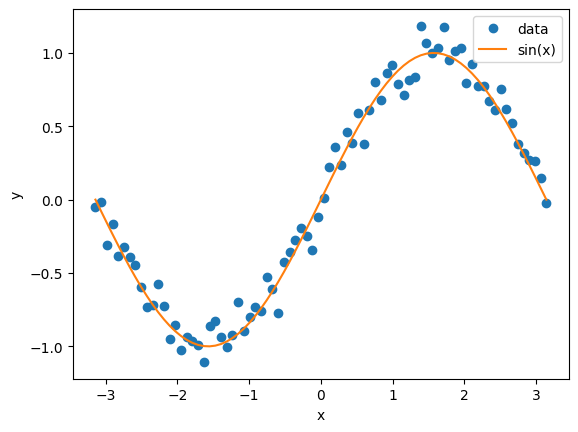

In [3]:
x = jnp.linspace(-jnp.pi, jnp.pi, 8 * 10).reshape(-1, 1)
y = jnp.sin(x) + jr.normal(jr.PRNGKey(0), shape=x.shape) * 0.1

plt.plot(x, y, "o", label="data")
plt.plot(x, jnp.sin(x), label="sin(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## Define model and optimizer state

In [4]:
class Net(sk.TreeClass):
    def __init__(self, *, key: jax.Array):
        k1, k2, k3 = jr.split(key, 3)
        self.l1 = sk.nn.Linear(1, 32, key=k1)
        self.l2 = sk.nn.Linear(32, 8, key=k2)
        self.l3 = sk.nn.Linear(8, 1, key=k3)

    def __call__(self, x):
        x = jax.nn.tanh(self.l1(x))
        x = jax.nn.tanh(self.l2(x))
        x = self.l3(x)
        return x


net = sk.tree_mask(Net(key=jr.PRNGKey(0)))
print(sk.tree_summary(net))

┌──────────┬─────────┬─────┬───────┐
│Name      │Type     │Count│Size   │
├──────────┼─────────┼─────┼───────┤
│.l1.weight│f32[1,32]│32   │128.00B│
├──────────┼─────────┼─────┼───────┤
│.l1.bias  │f32[32]  │32   │128.00B│
├──────────┼─────────┼─────┼───────┤
│.l2.weight│f32[32,8]│256  │1.00KB │
├──────────┼─────────┼─────┼───────┤
│.l2.bias  │f32[8]   │8    │32.00B │
├──────────┼─────────┼─────┼───────┤
│.l3.weight│f32[8,1] │8    │32.00B │
├──────────┼─────────┼─────┼───────┤
│.l3.bias  │f32[1]   │1    │4.00B  │
├──────────┼─────────┼─────┼───────┤
│Σ         │Net      │337  │1.32KB │
└──────────┴─────────┴─────┴───────┘


## Model parallelism

The idea here is to construct a `NamedSharding` object for model parallelism with max divisble axis choosen to shard.

In [5]:
def model_shard(mesh, leaf):
    # shard the largest dimension divisible by number of devices for model axis
    spec = [None] * len(leaf.shape)
    max_index_size = (None, 0)
    model_devices = mesh.shape["model"]

    for index, size in enumerate(leaf.shape):
        if size % model_devices == 0:
            max_index_size = max(max_index_size, (index, size), key=lambda x: x[1])

    index, _ = max_index_size

    if index is None:
        # if no dimension is divisible by model devices
        return js.NamedSharding(mesh, js.PartitionSpec())

    spec[max_index_size[0]] = "model"
    return js.NamedSharding(mesh, js.PartitionSpec(*spec))


net_sharding = jax.tree_map(ft.partial(model_shard, mesh), net)

sample_net = jax.device_put(net, net_sharding)


def viz_sharding_with_path(path, leaf):
    if isinstance(leaf, jax.Array):
        print(jax.tree_util.keystr(path))
        jax.debug.visualize_array_sharding(leaf)


# visualize the sharding of the network
jax.tree_util.tree_map_with_path(viz_sharding_with_path, sample_net)

.l1.weight


.l1.bias


 CPU 0,1  CPU 2,3  CPU 4,5  CPU 6,7 
                                    

.l2.weight


         
 CPU 0,1 
         
         
 CPU 2,3 
         
         
 CPU 4,5 
         
         
 CPU 6,7 
         

.l2.bias


 CPU 0,1  CPU 2,3  CPU 4,5  CPU 6,7 
                                    

.l3.weight


         
 CPU 0,1 
         
         
 CPU 2,3 
         
         
 CPU 4,5 
         
         
 CPU 6,7 
         

.l3.bias


   CPU 0,1,2,3,4,5,6,7   
                         

Net(
  l1=Linear(
    in_features=(#1), 
    out_features=#32, 
    weight_init=#glorot_uniform, 
    bias_init=#zeros, 
    weight=None, 
    bias=None
  ), 
  l2=Linear(
    in_features=(#32), 
    out_features=#8, 
    weight_init=#glorot_uniform, 
    bias_init=#zeros, 
    weight=None, 
    bias=None
  ), 
  l3=Linear(
    in_features=(#8), 
    out_features=#1, 
    weight_init=#glorot_uniform, 
    bias_init=#zeros, 
    weight=None, 
    bias=None
  )
)

## Data parallelism

In [6]:
# shard along the leading dimension
data_shrding = js.NamedSharding(mesh, js.PartitionSpec("data"))
x_shard = jax.device_put(x, data_shrding)
y_shard = jax.device_put(y, data_shrding)

# [80,1] -(2 devices)-> [40,1],[40,1]
jax.debug.visualize_array_sharding(x_shard)
print(f"unsharded shape =\t{x_shard.shape}")
print(f"sharded shape =\t\t{x_shard.sharding.shard_shape(x_shard.shape)}")

           
           
CPU 0,2,4,6
           
           
           
           
           
CPU 1,3,5,7
           
           
           

unsharded shape =	(80, 1)
sharded shape =		(40, 1)


## Train

Putting it all together

In [7]:
config = ConfigDict()
config.sharding = ConfigDict()
config.sharding.data_size = 2
config.sharding.model_size = 4
config.optim = ConfigDict()
config.optim.learning_rate = 1e-3
config.epochs = 1_000
config.net = None
config.key = jr.PRNGKey(0)
config.optim.optim_state = None


def mse(x, y):
    assert x.shape == y.shape, f"{x.shape} != {y.shape}"
    return jnp.mean((x - y) ** 2)


def loss_func(net, x, y):
    return mse(sk.tree_unmask(net)(x), y)


def train(config: ConfigDict, inputs: jax.Array, targets: jax.Array) -> Net:
    optim = optax.adam(config.optim.learning_rate)

    if config.net is None:
        net = sk.tree_mask(Net(key=config.key))

    if config.optim.optim_state is None:
        optim_state = optim.init(net)

    devices = mesh_utils.create_device_mesh((8))
    devices = devices.reshape(config.sharding.model_size, config.sharding.data_size)
    mesh = js.Mesh(devices, axis_names=("model", "data"))

    # data parallelism
    data_sharding = js.NamedSharding(mesh, js.PartitionSpec("data"))
    inputs = jax.device_put(inputs, data_sharding)
    targets = jax.device_put(targets, data_sharding)

    # model parallelism
    net_sharding = jax.tree_map(ft.partial(model_shard, mesh), net)
    net = jax.device_put(net, net_sharding)
    optim_state_sharding = jax.tree_map(ft.partial(model_shard, mesh), optim_state)
    optim_state = jax.device_put(optim_state, optim_state_sharding)

    @jax.jit
    def train_step(net: Net, optim_state):
        loss, grads = jax.value_and_grad(loss_func)(net, inputs, targets)
        grads = jax.lax.with_sharding_constraint(grads, net_sharding)
        updates, optim_state = optim.update(grads, optim_state)
        net = optax.apply_updates(net, updates)
        return net, optim_state, loss

    for _ in (pbar := tqdm(range(1, 1_000 + 1))):
        net, optim_state, loss = train_step(net, optim_state)
        pbar.set_description(f"loss = {loss:.3e}")

    return sk.tree_unmask(net)


net = train(config, x, y)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Visualize results

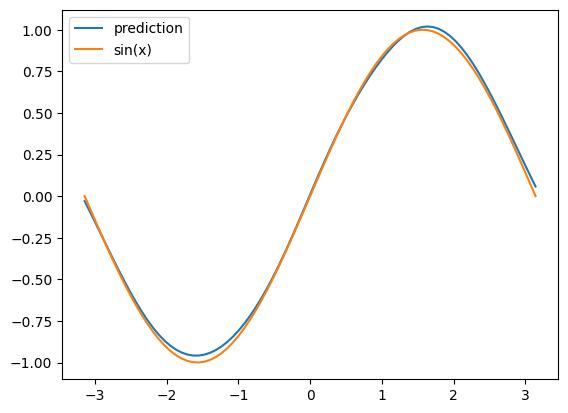

In [8]:
plt.plot(x, net(x), label="prediction")
plt.plot(x, jnp.sin(x), label="sin(x)")
plt.legend()